In [1]:
import GEMS
import pandas as pd
import numpy as np
import os


import pickle
from etcpy import etc
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [2]:
path = '../'
params = pd.read_csv(os.path.join(path,'data/model_enzyme_params.csv'),index_col=0)
dfae_batch,dfan_batch = GEMS.load_exp_batch_data(os.path.join(path,'data/ExpGrowth.tsv'))
dfchemo = pd.read_csv(os.path.join(path,'data/Chemostat_exp_data.txt'),sep='\t',index_col=0)

In [3]:
def aerobic(params):
    # thermalParams: a dictionary with ids like uniprotid_Topt 
    df = etc.calculate_thermal_params(params)
    mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    
    try: rae = etc.simulate_growth(mae,dfae_batch.index+273.15,df=df,sigma=0.5)
    except: rae = np.zeros(dfae_batch.shape[0])
    
    rae = [0 if x is None else x for x in rae]
    rae = [0 if x<1e-3 else x for x in rae]
    print(rae)
    rexp = GEMS.aerobic_exp_data()['data']
    
    print('r2_batch:',r2_score(rexp,rae))
    print('MSE_ae',MSE(rexp,rae))
    return {'data':np.array(rae)}

In [4]:
def anaerobic(params):
    df = etc.calculate_thermal_params(params)
    man = pickle.load(open(os.path.join(path,'models/anaerobic.pkl'),'rb'))

    try: ran = etc.simulate_growth(man,dfan_batch.index+273.15,df=df,sigma=0.5)
    except: ran = np.zeros(dfan_batch.shape[0])
    ran = [0 if x is None else x for x in ran]
    rexp = GEMS.anaerobic_exp_data()['data']
    
    print('r2_batch_an:',r2_score(rexp,ran))
    print('MSE_an',MSE(rexp,ran))

    return  {'data':np.array(ran)}

In [5]:
def chemostat(params):
    
    mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    exp_flux = GEMS.chemostat_exp_data()['data']
    
    growth_id = 'r_2111'
    glc_up_id = 'r_1714_REV'
    prot_pool_id = 'prot_pool_exchange'
    dilut = 0.1
    sigma = 0.5
    
    try:
        solution = etc.simulate_chomostat(mae,dilut,params,dfchemo.index+273.15,
                                              sigma,growth_id,glc_up_id,prot_pool_id)

        # Extract fluxes
        rxn_lst = [
                'r_1714_REV',#Glucose
                'r_1672', #CO2
                'r_1761', # Ethanol
            ]
        columns = ['Glucose','CO2','Ethanol']

        pred_flux = []
        for i,rxn_id in enumerate(rxn_lst):
            x = [s.fluxes[rxn_id] for s in solution]
            x.extend([0]*(len(dfchemo.index)-len(x)))
            pred_flux += x
        print(pred_flux)
    
    except: pred_flux = [0 for item in exp_flux]
    
    print('r2_flux:',r2_score(exp_flux,pred_flux))
    print('MSE_chemo',MSE(exp_flux,pred_flux))

    return  {'data':np.array(pred_flux)}

In [6]:
rae = aerobic(params)

Academic license - for non-commercial use only
Read LP format model from file /tmp/tmpo4h8a3nq.lp
Reading time = 0.05 seconds
: 3389 rows, 13486 columns, 49610 nonzeros
16.0 0.087306702476166
22.0 0.2105560124291127
26.0 0.305890505795534
29.0 0.36491875349427655
34.0 0.37945732248207237
37.0 0.35910203900616283
40.0 0.312006188736625
42.0 0.2620948315998482
[0.087306702476166, 0.2105560124291127, 0.305890505795534, 0.36491875349427655, 0.37945732248207237, 0.35910203900616283, 0.312006188736625, 0.2620948315998482]
r2_batch: -0.43123011530175104
MSE_ae 0.01740509998030239


In [7]:
ran = anaerobic(params)

Read LP format model from file /tmp/tmpd4gf1b_4.lp
Reading time = 0.07 seconds
: 3389 rows, 13486 columns, 49608 nonzeros
5.0 0.0010675427123762536
10.0 0.017988415161135696
15.0 0.06107538589205637
18.5 0.11365063900037399
22.5 0.19356290453072322
26.30000000000001 0.2740670272243529
30.0 0.3314700800963973
31.0 0.33765889285433615
33.0 0.33671223223868413
34.0 0.33405644555961755
35.0 0.3303851326221864
37.5 0.31128642415183544
40.0 0.2763968592062562
r2_batch_an: 0.6412713228219331
MSE_an 0.004510357215151777


In [8]:
chem  = chemostat(params)

Read LP format model from file /tmp/tmp1whp9vkl.lp
Reading time = 0.03 seconds
: 3389 rows, 13486 columns, 49610 nonzeros
[1.0784201625625673, 1.3562481219350546, 1.3684950452976214, 1.374357446005284, 1.3803342007313788, 1.3865502041239934, 2.851180214746377, 4.518147970981268, 4.591629511156707, 4.626803915402663, 4.662664443759244, 4.699960464115004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
r2_flux: -0.3580325510358968
MSE_chemo 38.57505418774239


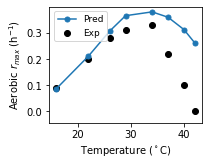

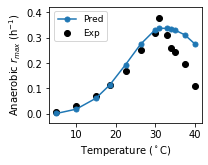

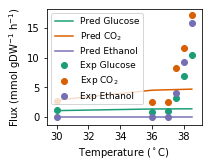

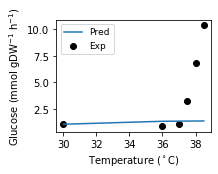

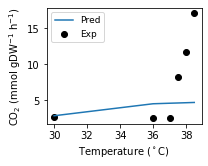

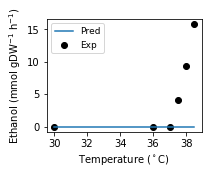

In [18]:
plt.figure(figsize=(3,2.4))
plt.scatter(dfae_batch.index,dfae_batch['r_ae'].values,label='Exp',color='k')
plt.plot(dfae_batch.index,rae['data'],markersize=5,marker='o',label='Pred')
plt.xlabel('Temperature ($^\circ$C)')
#plt.ylabel('Specific growth rate (h$^{-1}$)')
plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')

plt.legend(fontsize=9,loc='upper left')
plt.tight_layout()
plt.savefig('../figures/simulated_results_with_start_points_ae_batch.pdf')
plt.show()

plt.figure(figsize=(3,2.4))
plt.scatter(dfan_batch.index,dfan_batch['r_an'].values,label='Exp',color='k')
plt.plot(dfan_batch.index,ran['data'],markersize=5,marker='o',label='Pred')
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig('../figures/simulated_results_with_start_points_an_batch.pdf')
plt.show()

plt.figure(figsize=(3,2.4))
mets = ['Glucose','CO2','Ethanol']
labels = ['Glucose','CO$_2$','Ethanol']
cs = ['#1b9e77', '#d95f02', '#7570b3']
for i in range(3):
    plt.scatter(dfchemo.index, dfchemo[mets[i]],label='Exp {0}'.format(labels[i]),color=cs[i])
    plt.plot(dfchemo.index, chem['data'][i*6:(i+1)*6],label='Pred {0}'.format(labels[i]),color=cs[i])
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Flux (mmol gDW$^{-1}$ h$^{-1}$)')
plt.legend(fontsize=9)

plt.tight_layout()
plt.savefig('../figures/simulated_results_with_start_points_ae_chemo.pdf')
plt.show()


mets = ['Glucose','CO2','Ethanol']
labels = ['Glucose','CO$_2$','Ethanol']
cs = ['#1b9e77', '#d95f02', '#7570b3']
for i in range(3):
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfchemo.index, dfchemo[mets[i]],label='Exp'.format(labels[i]),color='k')
    plt.plot(dfchemo.index, chem['data'][i*6:(i+1)*6],label='Pred'.format(labels[i]))
    plt.xlabel('Temperature ($^\circ$C)')
    plt.ylabel(labels[i]+' (mmol gDW$^{-1}$ h$^{-1}$)')
    plt.legend(fontsize=9)

    plt.tight_layout()
    plt.savefig('../figures/simulated_results_with_start_points_ae_chemo_{0}.pdf'.format(mets[i]))
    plt.show()
